# EUROCONTROL area flights plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime
from scipy.optimize import leastsq

path = "~/git/FlyingClimate/"

In [2]:
# load opensky flight data
file = pd.read_csv(path+"data/EURO_2010_2021.csv")
dates_ori = file["Date"]
nflights = file["N_Flights"].to_numpy()

In [6]:
dates = [0,]*len(dates_ori)

for i in range(len(dates_ori)):
    day,month,year = dates_ori[i].split("/")
    dates[i] = datetime.date(int(year),int(month),int(day))
    
dayssince2010 = np.array([(d-datetime.date(2010,1,1)).days for d in dates])

In [7]:
# weekly averages
n = len(nflights)
n_divisible_by_7 = n // 7 * 7
nflights_weekly = nflights[n-n_divisible_by_7:n].reshape(-1,7).mean(axis=1)

dates_weekly = [dates[n-n_divisible_by_7] + i*datetime.timedelta(7) for i in range(len(nflights_weekly))]

In [8]:
# p% fit

# indices in dates lists that correspond to the respective dates
# time series starts jan1 to have 9 full years (avoid seasonality)
jan1 = [i for i in range(len(dates)) if dates[i] == datetime.date(2020,1,1)][0]

# p% annual increase model
def peval(x, p):
    return p[0] * p[1]**(x/365.25)

def residuals(p,y,x):
    return y - peval(x,p)

p0 = [0,3]
plsq = leastsq(residuals, p0, args=(nflights[:jan1], dayssince2010[:jan1]))
nflights_growth = peval(dayssince2010,plsq[0])  # no covid scenario

In [9]:
# p% increase from fit
(plsq[0][1]-1)*100

2.035666421222948

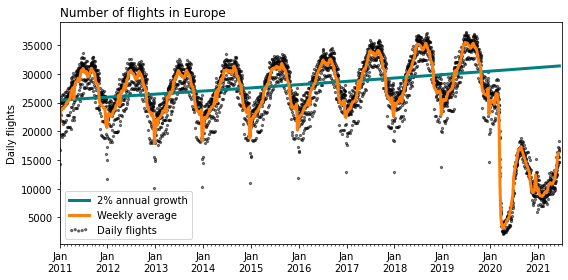

In [10]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(dates,nflights_growth,"teal",lw=3,label="2% annual growth")
ax.scatter(dates,nflights,5,"k",alpha=.5,label="Daily flights")
ax.plot(dates_weekly,nflights_weekly,"C1",lw=3,label="Weekly average")

# ax.set_xlabel("year")
ax.set_ylabel("Daily flights")
ax.set_title("Number of flights in Europe",loc="left")
ax.legend(loc=3,scatterpoints=5)
ax.set_xlim(datetime.date(2011,1,1),datetime.date(2021,7,1))

ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
plt.tight_layout()
plt.savefig("../plots/euroflights.pdf")
plt.savefig("../plots/euroflights.png",dpi=200)